In [2]:
import h5py
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.stats import norm
from tabulate import tabulate
import pandas as pd
from matplotlib import cm
from scipy.interpolate import interp2d
import os
import scipy.io as sio
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import time
PI = np.pi

In [44]:
def delay_signal(signal, delay=2000, w=500, seed=69):
    np.random.seed(seed)
    noise_samp = signal[:w]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    noise = np.random.normal(mean, 0.9*std, delay)
    return np.hstack([noise, signal])

def dkl(signal, i, k, l, w):
    #print(i,k,l,w)
    signal = delay_signal(signal, delay=w)
    vj = signal[i+w:i+w+w]
    vjk = signal[i-k+w:i+w+w-k]
    vjl = signal[i-l+w:i+w+w-l]
    vjkl = signal[i-k-l+w:i+w+w-k-l]
    return vj - vjk - vjl + vjkl
    
def s(signal, start_rise, tau, peaking_time, gap_time, w=0):
    if w == 0:
        w = int(round(2.5*peaking_time+gap_time, 0))
    ss = []
    dkl_s = dkl(signal, start_rise, peaking_time, peaking_time+gap_time, w)
    for j in range(w):
        if j == 0:
            ss.append(0)
        else:
            ss.append(ss[j-1]*(1+1/tau)+ dkl_s[j])
    return np.array(ss)

def get_kv2(v):
    Max_Ind = np.argmax(v)
    step = 10
#     Peak_mu = np.mean(v[Max_Ind:Max_Ind+step])
#     Peak_std = np.std(v[Max_Ind:Max_Ind+step])
    maxmax_roof = np.max(v)
#     mu_floor = np.mean(v[0:500])
#     std_floor = np.std(v[0:500])
    minmax_floor = np.max(v[0:200])
    # now run through the array from 0 up to Max_Ind + 20
    N = []

#     for n in range(len(v[0:Max_Ind+step])):
#         if ((v[n]>minmax_floor*2) and (v[n]<Peak_mu-Peak_std)):
#             N.append(n)
#     return np.array([N[0],N[-1], N[-1]-N[0]])

    for n in range(len(v[0:Max_Ind+step])):
        if ((v[n]>minmax_floor*1.8) and (v[n]<0.98*maxmax_roof)):
            N.append(n)
    return np.array([N[0],N[-1], N[-1]-N[0]])
    #return np.array(N[0])
    
def DAQ_Echo(Time_Stamps):
    echo_index = []
    for n in range(len(times)-1):
        if times[n+1]<times[n]:
            echo_index.append(n)
    return echo_index[0]
    
def Filter_Signals(v_raw):
    v_raw = savgol_filter(v_raw, 51, 2) # maybe play with filtering
    noise = np.mean(v_raw[0:100])
    v = v_raw - noise
    return v

def only_get_rise(v):
    Rise_Info = []
    for n in range(v.shape[0]):
        Rise_Info.append(get_kv2(v[n]))
    return np.array(Rise_Info)

def Filter_Signals_Get_Rise(Data):
    Smooted_data = []
    Rise_Info = []
    for n in range(Data.shape[0]):
        v_raw = savgol_filter(Data[n,:], 51, 2) # maybe play with filtering
        noise = np.mean(v_raw[0:100])
        v = v_raw - noise
        try:
            Rise_Info.append(get_kv2(v))
            Smooted_data.append(v)
        except Exception:
            pass
    return np.array(Smooted_data), np.array(Rise_Info)

# def Filter_Signals_Get_Rise(Data,time_stamps):
#     Smooted_data = []
#     Rise_Info = []
#     TS = DAQ_Echo(Time_Stamps=time_stamps)
#     for n in range(TS):
#         v_raw = savgol_filter(Data[n,:], 51, 2) # maybe play with filtering
#         noise = np.mean(v_raw[0:100])
#         v = v_raw - noise
#         try:
#             Rise_Info.append(get_kv2(v))
#             Smooted_data.append(v)
#         except Exception:
#             pass
#     return np.array(Smooted_data), np.array(Rise_Info)

def Exp_Func(x,A,m):
    return A*np.exp(-m*x)

def Exp_Fit(x,y):
    popt, pcov = curve_fit(Exp_Func,x,y)
    return popt


def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt, pcov

def Lin_Func(x,m,b):
    return m*x+b

def Lin_Fit(x,y):
    popt, pcov = curve_fit(Lin_Func,x,y)
    return popt

def Energy_Func(x,b,a1,a2,a3,a4,a5):
    return b + a1*x + a2*x**2 + a3*x**3 + a4*x**4 + a5*x**5

def Energy_Fit(x,y):
    popt, pcov = curve_fit(Energy_Func,x,y)
    return popt

def Generate_Trap_Amps(Signal_Dirr, file_name, K, GT, Tau):
    os.chdir(Signal_Dirr)
    f_name = file_name
    f = h5py.File(f_name, 'r')
    key1 = 'event_data'
    key2 = 'raw_data'
    branch1 = 'timestamp'
#     times = f[key1][branch1]
#     times = np.array(times)
    Data = f[key2]
    Data = np.array(Data)
    #Signals_Smooth = [Filter_Signals(Data[n,:]) for n in range(Data.shape[0])]
    Signals_Smooth, Rise_Info = Filter_Signals_Get_Rise(Data)
    #Signals_Smooth, Rise_Info = Filter_Signals_Get_Rise(Data,times)
    print('The Smoothing is complete')
    DL = Signals_Smooth.shape[0]
    #Rise_Info = np.array([get_kv2(Signals_Smooth[n]) for n in range(Data.shape[0])])
    k = Rise_Info[:,2] # rise time
    r = Rise_Info[:,1] # end rise
    i = Rise_Info[:,0] # start rise
    mean_k = int(np.mean(k)) # mean rise time
    print('the mean value for k is ',mean_k)
    V = np.array(Signals_Smooth)
    if K == 0:
        K = mean_k
    else:
        K = K
    
    trappy = np.array([s(signal=V[n], start_rise=i[n], tau=Tau, peaking_time=K,gap_time=GT) for n in range(DL)])
    
    Y = []
    for n in range(DL):
        Y.append(np.max(trappy[n]))
    Y = np.array(Y)
    
    return Y

def Get_Hist_Mus(Y,Upperlimit,Del,Source):
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    # Create 2x2 sub plots
    H, binz = np.histogram(Y,bins=2**11)
#     peaks, _ = find_peaks(H[2:-1], height=np.argmax(H[2:-1]))
#     bin_peaks = np.sort(binz[peaks])
    Mus = []
    stds = []
    if Source == 'Cs137':
        peak, _ = find_peaks(H[2:-1], height=np.max(H[2:-1]))
        ind = [binz[peak]]
    else:
        peak1, _ = find_peaks(H[2:-1], height=np.max(H[2:-1]))
        ind1 = binz[peak1]
        x1,x2 = ind1-Del, ind1+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        x = binz[b0:b1] 
        gf = fp[0] + fp[1]*np.exp(-(x - fp[2]) ** 2 / (2 * fp[3] ** 2))
        # plt.show()
        Hnew = np.copy(H)
        change = Hnew[b0:b1] - gf
        Hnew[b0:b1] = change
        peak2 = np.argmax(Hnew[2:-1])
        
        ind = [binz[peak1], binz[peak2]]

    for n in range(len(ind)):
        x1,x2 = ind[n]-Del, ind[n]+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        offset, A, mu, std = fp
        Mus.append(mu)
        stds.append(std)
        Res = 2*np.sqrt(2*np.log(2))*100*std/mu
        print('The res is ',Res)

        #plt.figure(figsize=(8,6))
        #plotting
        gs = gridspec.GridSpec(2, 2)
        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(gs[0, :]) # row 0, span all columns
        ax2 = fig.add_subplot(gs[1, 0]) # row 1, col 0
        ax3 = fig.add_subplot(gs[1, 1]) # row 1, col 1
        
        ax1.hist(Y, bins=2**11)
        ax1.set_title(Source)
        
        ax2.hist(Y, bins=2**11)
        ax2.plot(binz[b0:b1], gauss(binz[b0:b1], *fp),label='Res='+str(round(Res,3))+'%')
        ax2.set_title(Source+' with Gaussian Fit Overlay',fontsize=10)
        ax2.legend()
        ax3.plot(binz[b0:b1], H[b0:b1])
        ax3.plot(binz[b0:b1], gauss(binz[b0:b1], *fp))
        title = "Fit results "+Source+": $\mu$ = %.2f,  $\sigma$ = %.2f" % (mu, std)
        ax3.set_title(title,fontsize=10)
        #plt.show()
        fig.tight_layout()
        #fig.show()
    return np.array(Mus), np.array(stds)

    
def Get_Hist_Mus_calibrated(Y,Upperlimit,Del,Source,Calb):
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    # Create 2x2 sub plots
    H, binz = np.histogram(Y,bins=2**11)
    Del = Lin_Func(Del,*Calb)
    binz = Lin_Func(binz,*Calb)
#     peaks, _ = find_peaks(H[2:-1], height=np.argmax(H[2:-1]))
#     bin_peaks = np.sort(binz[peaks])
    Mus = []
    if Source == 'Cs137':
        peak, _ = find_peaks(H[2:-1], height=np.max(H[2:-1]))
        ind = [binz[peak]]
    else:
        peak1, _ = find_peaks(H[2:-1], height=np.max(H[2:-1]))
        ind1 = binz[peak1]
        x1,x2 = ind1-Del, ind1+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        x = binz[b0:b1] 
        gf = fp[0] + fp[1]*np.exp(-(x - fp[2]) ** 2 / (2 * fp[3] ** 2))
        # plt.show()
        Hnew = np.copy(H)
        change = Hnew[b0:b1] - gf
        Hnew[b0:b1] = change
        peak2 = np.argmax(Hnew[2:-1])
        
        ind = [binz[peak1], binz[peak2]]

    for n in range(len(ind)):
        x1,x2 = ind[n]-Del, ind[n]+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        offset, A, mu, std = fp
        Mus.append(mu)
        Res = 2*np.sqrt(2*np.log(2))*100*std/mu
        print('The res is ',Res)

        #plt.figure(figsize=(8,6))
        #plotting
        gs = gridspec.GridSpec(2, 2)
        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(gs[0, :]) # row 0, span all columns
        ax2 = fig.add_subplot(gs[1, 0]) # row 1, col 0
        ax3 = fig.add_subplot(gs[1, 1]) # row 1, col 1
        
        #ax1.hist(Y, bins=2**11)
        ax1.hist(binz[:-1], binz, weights=H)
        ax1.set_title(Source)
        
        #ax2.bar(binz[:-1],H)
        ax2.hist(binz[:-1], binz, weights=H)
        ax2.plot(binz[b0:b1], gauss(binz[b0:b1], *fp),label='Res='+str(round(Res,3))+'%')
        ax2.set_title(Source+' with Gaussian Fit Overlay',fontsize=10)
        ax2.legend()
        ax3.plot(binz[b0:b1], H[b0:b1])
        ax3.plot(binz[b0:b1], gauss(binz[b0:b1], *fp))
        title = "Fit results "+Source+": $\mu$ = %.2f" % (mu)
        ax3.set_title(title,fontsize=10)
        #plt.show()
        fig.tight_layout()
        #fig.show()
    return np.array(Mus)
    

def Reduce_Histo(H,binz,Ind,Del):
    x1,x2 = Ind-Del, Ind+Del
    b0 = np.argmin(np.abs(binz - x1))
    b1 = np.argmin(np.abs(binz - x2))
    fp = gauss_fit(binz[b0:b1], H[b0:b1])
#     offset, A, mu, std = test_gauss
#     Res = 2*np.sqrt(2*np.log(2))*100*std/mu
    x = binz[b0:b1] 
    gf = fp[0] + fp[1]*np.exp(-(x - fp[2]) ** 2 / (2 * fp[3] ** 2))
    # plt.show()
    Hnew = np.copy(H)
    #change = Hnew[b0:b1] - gf
    change = Hnew[b0:b1] - Hnew[b0:b1]
    Hnew[b0:b1] = change
    peak = np.argmax(Hnew[2:-1])

    return Hnew, peak




def Get_Hist_Mus_calibrated_V1(Y,Upperlimit,Del,Source,num_peaks):
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    # Create 2x2 sub plots
    if Source == 'Th228':
        Cond2 = Y<6.0E+04
        Y[Cond2] = 0
    
    H, binz = np.histogram(Y,bins=2**11)
#     peaks, _ = find_peaks(H[2:-1], height=np.argmax(H[2:-1]))
#     bin_peaks = np.sort(binz[peaks])
    Mus = []
    stds = []
    ind = []
    ind.append(binz[np.argmax(H[2:-1])])
    H_mod = np.copy(H)
    for i in range(num_peaks-1):
        Max_Ind = np.argmax(H_mod[2:-1])
        Max_Ind = binz[Max_Ind]
        H_mod, Peak = Reduce_Histo(H=H_mod, binz=binz, Ind=Max_Ind, Del=Del)
        ind.append(binz[Peak])

    for n in range(len(ind)):
        x1,x2 = ind[n]-Del, ind[n]+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        offset, A, mu, std = fp
        Res = 2*np.sqrt(2*np.log(2))*100*std/mu
        if Res<5:
            Mus.append(mu)
            stds.append(std)
        print('The res is ',Res)

        #plt.figure(figsize=(8,6))
        #plotting
        gs = gridspec.GridSpec(2, 2)
        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(gs[0, :]) # row 0, span all columns
        ax2 = fig.add_subplot(gs[1, 0]) # row 1, col 0
        ax3 = fig.add_subplot(gs[1, 1]) # row 1, col 1

        #ax1.hist(Y, bins=2**11)
        ax1.hist(binz[:-1], binz, weights=H)
        ax1.set_title(Source)

        #ax2.bar(binz[:-1],H)
        ax2.hist(binz[:-1], binz, weights=H)
        ax2.plot(binz[b0:b1], gauss(binz[b0:b1], *fp),label='Res='+str(round(Res,3))+'%')
        ax2.set_title(Source+' with Gaussian Fit Overlay',fontsize=10)
        ax2.legend()
        ax3.plot(binz[b0:b1], H[b0:b1])
        ax3.plot(binz[b0:b1], gauss(binz[b0:b1], *fp))
        title = "Fit results "+Source+": $\mu$ = %.2f" % (mu)
        ax3.set_title(title,fontsize=10)
        #plt.show()
        fig.tight_layout()
        #fig.show()
    return np.array(Mus), np.array(stds)


def Get_Hist_Mus_calibrated_V2(Y,Upperlimit,Del,Source,Calb,num_peaks,num_bins):
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    # Create 2x2 sub plots
    if Source == 'Th228':
        Cond2 = Y<6.0E+04
        Y[Cond2] = 0
    
    H, binz = np.histogram(Y,bins=num_bins)
    Del = Energy_Func(Del,*Calb)
    binz = Energy_Func(binz,*Calb)
#     peaks, _ = find_peaks(H[2:-1], height=np.argmax(H[2:-1]))
#     bin_peaks = np.sort(binz[peaks])
    Mus = []
    ind = []
    ind.append(binz[np.argmax(H[2:-1])])
    H_mod = np.copy(H)
    for i in range(num_peaks-1):
        Max_Ind = np.argmax(H_mod[2:-1])
        Max_Ind = binz[Max_Ind]
        H_mod, Peak = Reduce_Histo(H=H_mod, binz=binz, Ind=Max_Ind, Del=Del)
        ind.append(binz[Peak])

    for n in range(len(ind)):
        x1,x2 = ind[n]-Del, ind[n]+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp,cov = gauss_fit(binz[b0:b1], H[b0:b1])
        offset, A, mu, std = fp
        Res = 2*np.sqrt(2*np.log(2))*100*std/mu
        C = 2*np.sqrt(2*np.log(2))*100
        err = np.sqrt(np.diag(cov))
        print(err)
        Perr = np.sqrt(C**2*(err[3]**2/mu**2 + std**2*err[2]**2/mu**2))
        if Res<5:
            Mus.append(mu)
        print('The res is ',Res)
        print('The uncertainty is',Perr)
        #plt.figure(figsize=(8,6))
        #plotting
        gs = gridspec.GridSpec(2, 2)
        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(gs[0, :]) # row 0, span all columns
        ax2 = fig.add_subplot(gs[1, 0]) # row 1, col 0
        ax3 = fig.add_subplot(gs[1, 1]) # row 1, col 1

        #ax1.hist(Y, bins=2**11)
        ax1.hist(binz[:-1], binz, weights=H)
        ax1.set_title(Source)

        #ax2.bar(binz[:-1],H)
        ax2.hist(binz[:-1], binz, weights=H)
        ax2.plot(binz[b0:b1], gauss(binz[b0:b1], *fp),label='Res='+str(round(Res,3))+'\u00B1'+str(round(Perr,4))+'%')
        ax2.set_title(Source+' with Gaussian Fit Overlay',fontsize=10)
        ax2.legend()
        ax3.plot(binz[b0:b1], H[b0:b1])
        ax3.plot(binz[b0:b1], gauss(binz[b0:b1], *fp))
        title = "Fit results "+Source+": $\mu$ = %.2f" % (mu)
        ax3.set_title(title,fontsize=10)
        #plt.show()
        fig.tight_layout()
        #fig.show()
    return np.array(Mus), np.array(H)#np.array(gauss(binz[b0:b1], *fp))


def Get_Ballistics(Y,Upperlimit,Del,Source,Calb,num_peaks):
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    # Create 2x2 sub plots
    if Source == 'Th228':
        Cond2 = Y<6.0E+04
        Y[Cond2] = 0
    
    H, binz = np.histogram(Y,bins=2**11)
    Del = Energy_Func(Del,*Calb)
    binz = Energy_Func(binz,*Calb)
#     peaks, _ = find_peaks(H[2:-1], height=np.argmax(H[2:-1]))
#     bin_peaks = np.sort(binz[peaks])
    Mus = []
    Resz = []
    ind = []
    ind.append(binz[np.argmax(H[2:-1])])
    H_mod = np.copy(H)
    for i in range(num_peaks-1):
        Max_Ind = np.argmax(H_mod[2:-1])
        Max_Ind = binz[Max_Ind]
        H_mod, Peak = Reduce_Histo(H=H_mod, binz=binz, Ind=Max_Ind, Del=Del)
        ind.append(binz[Peak])

    for n in range(len(ind)):
        x1,x2 = ind[n]-Del, ind[n]+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        offset, A, mu, std = fp
        Res = 2*np.sqrt(2*np.log(2))*100*std/mu
        Mus.append(mu)
        Resz.append(Res)
        print('The res is ',Res)

        #plt.figure(figsize=(8,6))
        #plotting
        gs = gridspec.GridSpec(2, 2)
        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(gs[0, :]) # row 0, span all columns
        ax2 = fig.add_subplot(gs[1, 0]) # row 1, col 0
        ax3 = fig.add_subplot(gs[1, 1]) # row 1, col 1

        #ax1.hist(Y, bins=2**11)
        ax1.hist(binz[:-1], binz, weights=H)
        ax1.set_title(Source)

        #ax2.bar(binz[:-1],H)
        ax2.hist(binz[:-1], binz, weights=H)
        ax2.plot(binz[b0:b1], gauss(binz[b0:b1], *fp),label='Res='+str(round(Res,3))+'%')
        ax2.set_title(Source+' with Gaussian Fit Overlay',fontsize=10)
        ax2.legend()
        ax3.plot(binz[b0:b1], H[b0:b1])
        ax3.plot(binz[b0:b1], gauss(binz[b0:b1], *fp))
        title = "Fit results "+Source+": $\mu$ = %.2f" % (mu)
        ax3.set_title(title,fontsize=10)
        #plt.show()
        fig.tight_layout()
        #fig.show()
    return np.array(Mus), np.array(Resz)


def Create_Calibrated_Spectrums(Y,Calb,Upperlimit):
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    H, binz= np.histogram(Y,bins=2**11)
    binz = Energy_Func(binz,*Calb)
    return H, binz
#     #fig = plt.figure()
#     plt.hist(binz[:-1], binz, weights=H, histtype='step')
#     plt.semilogy()
#     plt.xlabel('[keV]')
#     plt.ylabel('Counts')
#     plt.xlim(1,binz[-1]+100)
#     #plt.show()
#     plt.hold()


# Loading the smoothed signals and assinging them object names

In [7]:
%matplotlib widget
os.chdir(r'/Users/curtisberger/PythonPrograms/NE204/Lab2/Cluster_Res')
#fname = r'Datahdf5V2.h5'
fname = r'Datahdf5V3.h5'
F = h5py.File(fname, 'r')
Data = np.array(F['dataset'])
print(Data)
clust_nums = np.arange(0,10,1)

#unclustered data
fname = r'DataUnclusteredV3.h5'
F = h5py.File(fname, 'r')
Unclustered_data = np.array(F['dataset'])
    


[[-1.12157954e-01 -1.13390772e-01 -1.15566900e-01 ...  1.93018977e+02
   1.92669886e+02  0.00000000e+00]
 [-7.91307808e-01 -8.00159512e-01 -8.08513251e-01 ...  1.93081635e+02
   1.92905368e+02  0.00000000e+00]
 [-5.05461783e-01 -4.79190119e-01 -4.53484720e-01 ...  1.92235454e+02
   1.92166913e+02  0.00000000e+00]
 ...
 [ 2.07251672e+00  1.97546558e+00  1.88094991e+00 ...  1.90306560e+02
   1.90210204e+02  9.00000000e+00]
 [-1.18032832e-01 -7.14930900e-02 -2.57374060e-02 ...  1.91145970e+02
   1.90938627e+02  9.00000000e+00]
 [-5.57869138e-01 -4.59520295e-01 -3.65699127e-01 ...  1.91661035e+02
   1.91422003e+02  9.00000000e+00]]


# Plotting to make sure we still have all the correct information

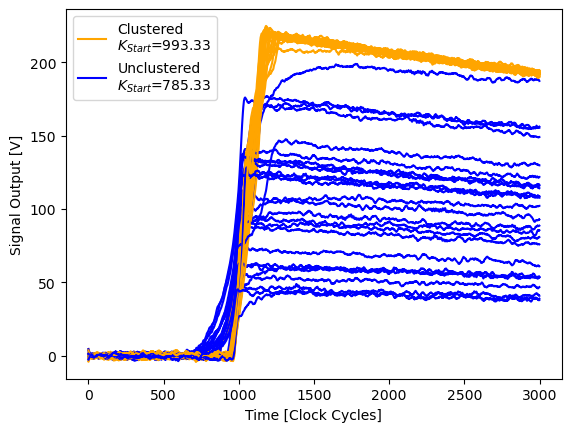

In [8]:
%matplotlib inline
Clustered_rises = only_get_rise(Data[:,0:-1])
UnClustered_rises = only_get_rise(Unclustered_data[:,0:3000])
AvgK_c = np.mean(Clustered_rises[0])
AvgK_unc = np.mean(UnClustered_rises[0])

os.chdir(r'/Users/curtisberger/PythonPrograms/NE204/Lab2/Imgs')
plt.figure()
for i in range(25):
    plt.plot(Data[i,0:-1],color = 'orange') # last column contains cluster number
    plt.plot(Unclustered_data[i,0:3000], color='blue')
plt.plot(Data[27,0:-1], label= 'Clustered\n$K_{Start}$='+str(round(AvgK_unc,2)),color = 'orange') # last column contains cluster number
plt.plot(Unclustered_data[27,0:3000],label='Unclustered\n$K_{Start}$='+str(round(AvgK_c,2)), color='blue')
plt.xlabel('Time [Clock Cycles]')
plt.ylabel('Signal Output [V]')
plt.legend()
plt.savefig('RawSignalCompare.png')

In [9]:
num_labels = []
for n in clust_nums:
    i = np.array(np.where(Data[:,-1]==n)).reshape(-1)
    num_labels.append(len(i))
num_labels = np.array(num_labels)

# Load the Optimized Clusters

In [10]:
os.chdir(r'/Users/curtisberger/PythonPrograms/NE204/Lab2/Cluster_Res/clusterv3/data')
#os.chdir(r'/Users/curtisberger/PythonPrograms/NE204/Lab2/Cluster_Res/clustersv2/Clusterdata')
#os.chdir(r'/Users/curtisberger/PythonPrograms/NE204/Lab2/Cluster_Res/clusters')
# print(d)
Opt_clusters = []
for f in os.listdir():
    if f.endswith('.mat'):
        print(f)
        d = sio.loadmat(f)
        Opt_clusters.append(d)

Cluster9.mat
Cluster8.mat
Cluster5.mat
Cluster4.mat
Cluster6.mat
Cluster7.mat
Cluster3.mat
Cluster2.mat
Cluster0.mat
Cluster1.mat


# Creating the original trapezoidal parameter dataframe

In [11]:
# Gaps = np.arange(100,910,10) # was 200 to 810
# Ks = np.arange(100,910,10)
Gaps = np.arange(300,810,10) # was 200 to 810
Ks = np.arange(300,810,10)
print(Ks.shape)
inds = np.ones((len(Ks)**2,2))
counter = 0
Df = pd.DataFrame(inds, columns=['Gaps', 'Ks'])
for i in range(len(Gaps)):
    for j in range(len(Ks)):
        Df['Gaps'][counter]=Gaps[i]
        Df['Ks'][counter]=Ks[j]
        counter+=1
        if counter == len(Ks)**2:
            break
print(Df)

(51,)
       Gaps     Ks
0     300.0  300.0
1     300.0  310.0
2     300.0  320.0
3     300.0  330.0
4     300.0  340.0
...     ...    ...
2596  800.0  760.0
2597  800.0  770.0
2598  800.0  780.0
2599  800.0  790.0
2600  800.0  800.0

[2601 rows x 2 columns]


0
0.36489135628263125
1199
(1510,)
(1510,)
1
0.15159039741074684
197
(1510,)
(1510,)
2
0.414408450137731
156
(1510,)
(1510,)
3
0.32518766913632896
436
(1612,)
(1612,)
4
0.30735692266880993
879
(1663,)
(1663,)
5
0.37669044120885736
1014
(1510,)
(1510,)
6
0.3437555364468006
1490
(1510,)
(1510,)
7
0.33438379654538974
1162
(1612,)
(1612,)
8
0.33042757544898826
1141
(1499,)
(1499,)
9
0.3623575333925978
1199
(1510,)
(1510,)


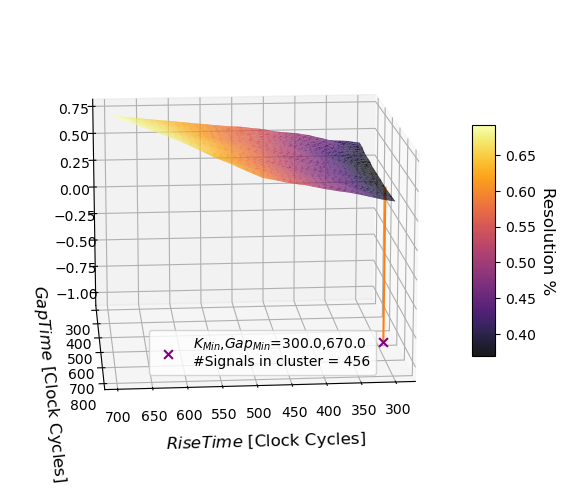

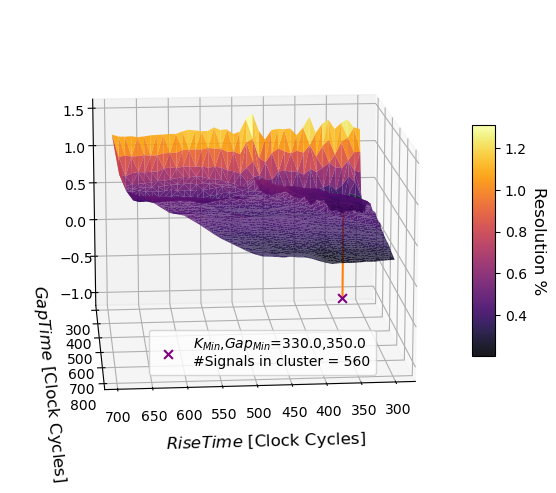

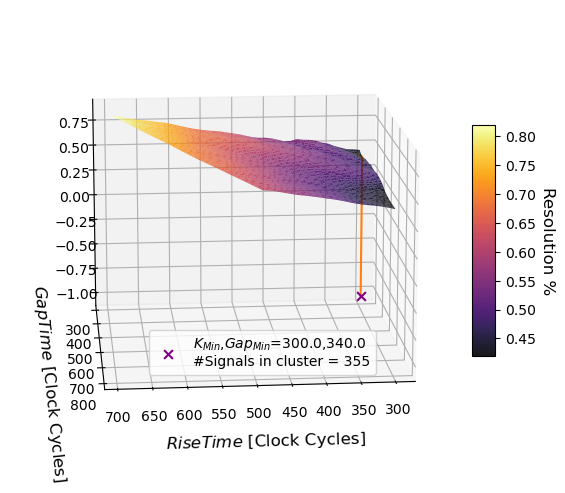

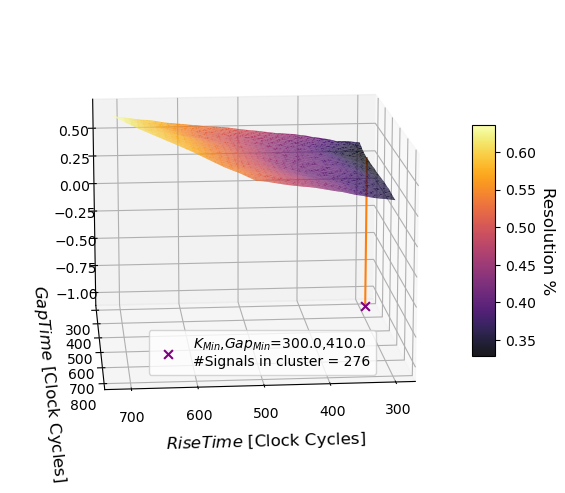

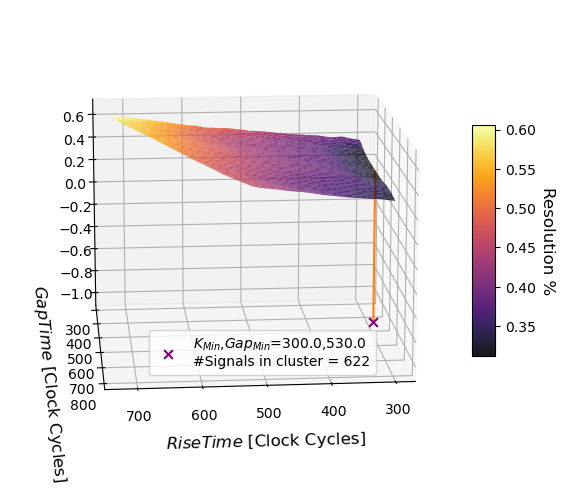

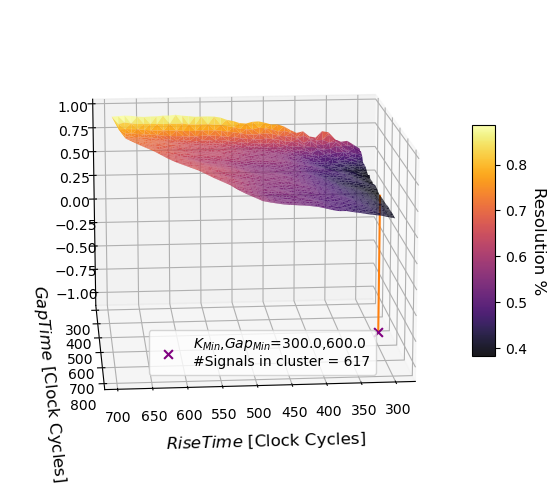

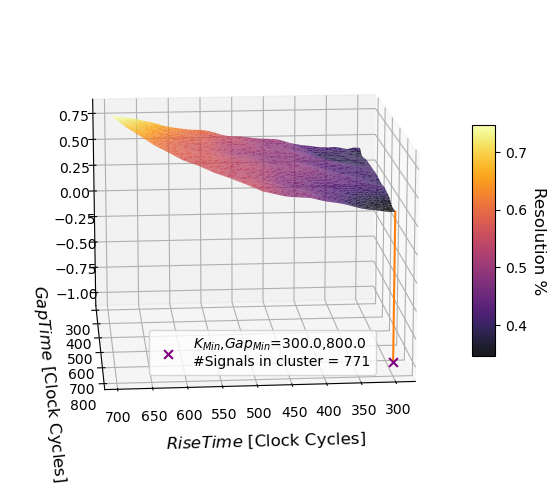

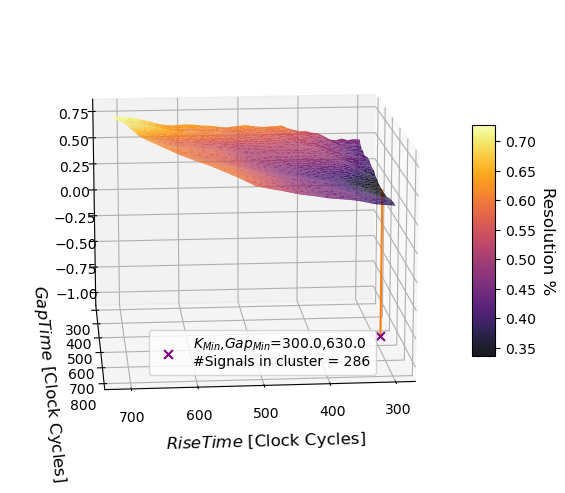

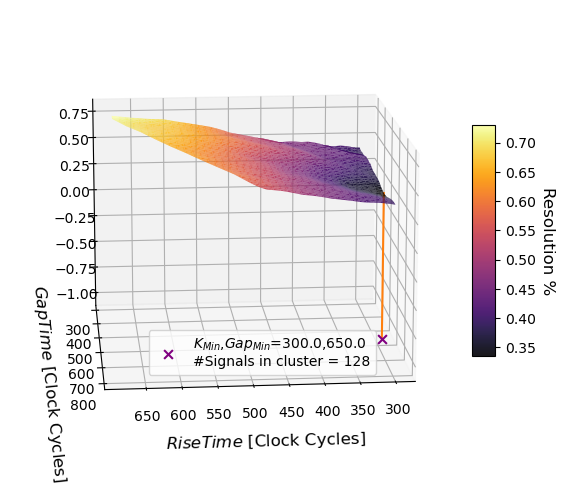

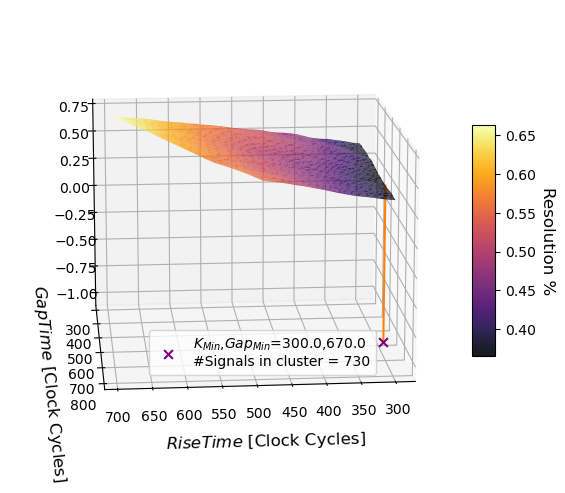

In [12]:
os.chdir(r'/Users/curtisberger/PythonPrograms/NE204/Lab2/imgs/OptimizerV2')
%matplotlib inline
Optimized_Ks = []
Optimized_Gaps = []
for i in range(10):
    print(i)
    indy = i
    Res = np.array(Opt_clusters[indy]['Resolutions']).reshape(-1)
    iss = np.array(Opt_clusters[indy]['Success Mask']).reshape(-1)
    x = np.array(Df['Ks'][iss])
    y = np.array(Df['Gaps'][iss])
    Z = np.copy(Res)
    cond1 = np.array(np.where((Z>=0) & (Z<50))).reshape(-1)
    Z = Z[cond1]
    x = x[cond1]
    y = y[cond1]
    MinI = np.argmin(Z)
    print(np.min(Z))
    print(MinI)
    xmin, ymin = x[MinI], y[MinI]
    Optimized_Ks.append(xmin)
    Optimized_Gaps.append(ymin)
    print(x.shape)
    print(Z.shape)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    #ax.set_zlim(-1, 2)
    surf = ax.plot_trisurf(x, y, Z,cmap = 'inferno',alpha=0.9)
    #ax.scatter(xmin, ymin, np.min(Z),marker='o',color='purple',s=40)
    minline = np.array([-1,np.min(Z)])
    xcoord = np.ones(2)*xmin
    ycoord = np.ones(2)*ymin
    ax.scatter(xmin, ymin, -1,marker='x',color='purple',s=40, 
               label='$K_{Min}$,$Gap_{Min}$='+str(xmin)+','+str(ymin)+'\n#Signals in cluster = '+str(num_labels[indy]))
    ax.plot(xcoord,ycoord,minline)
    ax.set_xlabel('$Rise Time$ [Clock Cycles]', labelpad=9, fontsize =12)
    ax.set_ylabel('$Gap Time$ [Clock Cycles]', labelpad=9,fontsize = 12)
    #ax.set_zlabel('$Resolution$ %', labelpad=9,fontsize = 14)
    #ax.set_title('Optimization Cluster'+str(indy),fontsize=16,pad=0.005)
    ax.legend(fancybox=True,loc=(0.3,0.21))
    ax.view_init(azim=85, elev=14)
    cbar = fig.colorbar(surf,shrink=0.5,aspect=10,pad=0.0001)
    cbar.set_label('Resolution %', rotation=270, labelpad=14, fontsize = 12)
    # x = np.linspace(200,810,int(len(Z)**.5))
    # y = np.linspace(200,810,int(len(Z)**.5))
#     N = int(len(Z)**.5)
#     z = Z.reshape(N,N)
#     plt.figure()
#     plt.imshow(z, cmap='plasma', extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)), aspect = 'auto')
#     plt.colorbar()
#     plt.show()
    # print(z.shape)
    bbox = fig.bbox_inches.from_bounds(0.5, 0.5, 8, 4)
    #plt.savefig('Optimizer'+str(indy)+'.png',bbox_inches=bbox)
    #plt.savefig('Optimizer'+str(indy)+'.png',bbox_inches='tight')

In [8]:
# %matplotlib inline
# y = list(np.array(Df['Gaps'][iss]))
# y = [*set(y)]
# y = np.sort(np.array(y))


# x = list(np.array(Df['Ks'][iss]))
# x = [*set(x)]
# x = np.sort(np.array(x))
# Z_ = np.zeros((len(y),len(x)))
# print(Z_.shape)
# for i in range(len(x)):
#     for j in range(len(y)):
#         Z_[j][i] = z[j][i]
# X,Y = np.meshgrid(x,y)

# xmin, ymin = np.unravel_index(np.argmin(Z_), Z_.shape)
# print(xmin, ymin)
# # min max points in 3D space (x,y,z)
# mi = (X[xmin,ymin], Y[xmin,ymin], Z_.min())
# Ami = np.array([mi]*4)

# for i, v in enumerate([200,800,-1]):
#     Ami[i,i] = v 
# # ======
# ## plot:
# plt.close('all')
# fig = plt.figure(figsize=(10,6))
# ax = plt.axes(projection='3d')
# surf = ax.plot_surface(X,Y,Z_, cmap = 'plasma',rstride=8, cstride=8, alpha=0.8)
# cset = ax.contour(X, Y, Z_, zdir='z',offset=-1, cmap='inferno')
# #ax.plot(Ami[:,0], Ami[:,1], Ami[:,2], marker="o", ls="", c=cm.coolwarm(0.))
# ax.scatter(X[xmin,ymin], Y[xmin,ymin],-1,marker='o', s=50,color='purple',
#            label='Local_Min = ('+str(x[xmin])+','+str(y[ymin])+')')
# ax.set_zlim(-1, 2)
# ax.set_xlabel('$GapTime$ [Clock Cycles]', labelpad=9, fontsize =14)
# ax.set_ylabel('$Rise Time$ [Clock Cycles]', labelpad=9,fontsize = 14)
# ax.set_zlabel('$Resolution$', labelpad=9,fontsize = 14)
# ax.set_title('Optimization',fontsize=16)
# ax.legend(fancybox=True)
# ax.view_init(azim=-35, elev=24)
# #fig.colorbar(surf,shrink=0.5,aspect=10)

# Load the Energy Calibration File Parameters.

In [13]:
os.chdir(r'/Users/curtisberger/PythonPrograms/NE204/Lab1/DATA/Combined_Data')
ECalb = sio.loadmat('ECalb.mat')['Energy_Calb'][0]

Raw_Mean = 185563.15


In [14]:
ULS = []
ULS.append(1.95E+05)
ULS.append(1.95E+05)

In [15]:
def Generate_K_Means_Traps(v, K, GT, Tau):
    Rise_Info = only_get_rise(v)
    #Signals_Smooth, Rise_Info = Filter_Signals_Get_Rise(Data,times)
    print('The Smoothing is complete')
    DL = v.shape[0]
    #Rise_Info = np.array([get_kv2(Signals_Smooth[n]) for n in range(Data.shape[0])])
    k = Rise_Info[:,2] # rise time
    r = Rise_Info[:,1] # end rise
    i = Rise_Info[:,0] # start rise
    mean_k = int(np.mean(k)) # mean rise time
#     print('the mean value for k is ',mean_k)
#     print(r)
    if K == 0:
        K = mean_k
    else:
        K = K
    
    trappy = np.array([s(signal=v[n], start_rise=i[n], tau=Tau, peaking_time=K,gap_time=GT) for n in range(DL)])
    
    Yt = []
    for n in range(DL):
        Yt.append(np.max(trappy[n]))
    Yt = np.array(Yt)
    
    return Yt

def Get_Hist_Mus_calibrated_VF(Y,Upperlimit,Del,Source,Calb,num_peaks, v, K, GT, Tau):
    Y = Generate_K_Means_Traps(v, K, GT, Tau)
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    # Create 2x2 sub plots
    if Source == 'Th228':
        Cond2 = Y<6.0E+04
        Y[Cond2] = 0
    
    H, binz = np.histogram(Y,bins=2**11)
    Del = Energy_Func(Del,*Calb)
    binz = Energy_Func(binz,*Calb)
#     peaks, _ = find_peaks(H[2:-1], height=np.argmax(H[2:-1]))
#     bin_peaks = np.sort(binz[peaks])
    Mus = []
    Resz = []
    ind = []
    ind.append(binz[np.argmax(H[10:-1])])
    H_mod = np.copy(H)
    for i in range(num_peaks-1):
        Max_Ind = np.argmax(H_mod[10:-1])
        Max_Ind = binz[Max_Ind]
        H_mod, Peak = Reduce_Histo(H=H_mod, binz=binz, Ind=Max_Ind, Del=Del)
        ind.append(binz[Peak])

    for n in range(len(ind)):
        x1,x2 = ind[n]-Del, ind[n]+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp,cov = gauss_fit(binz[b0:b1], H[b0:b1])
        offset, A, mu, std = fp
        Res = 2*np.sqrt(2*np.log(2))*100*std/mu
        err = np.sqrt(np.diag(cov))
        Resz.append(Res)
        if Res<5:
            Mus.append(mu)
        print('The res is ',Res)
        print('The uncertainity is',err)
        gs = gridspec.GridSpec(2, 2)
        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(gs[0, :]) # row 0, span all columns
        ax2 = fig.add_subplot(gs[1, 0]) # row 1, col 0
        ax3 = fig.add_subplot(gs[1, 1]) # row 1, col 1

        #ax1.hist(Y, bins=2**11)
        ax1.hist(binz[:-1], binz, weights=H)
        ax1.set_title(Source)
        ax1.set_xlabel('Energy [keV]',fontsize=10)
        #ax2.bar(binz[:-1],H)
        ax2.hist(binz[:-1], binz, weights=H)
        ax2.plot(binz[b0:b1], gauss(binz[b0:b1], *fp),label='Res='+str(round(Res,3))+'%')
        ax2.set_title(Source+' with Gaussian Fit Overlay',fontsize=10)
        ax2.set_xlabel('Energy [keV]',fontsize=10)
        ax2.legend()
        ax3.plot(binz[b0:b1], H[b0:b1])
        ax3.plot(binz[b0:b1], gauss(binz[b0:b1], *fp))
        ax3.set_xlabel('Energy [keV]',fontsize=10)
        title = "Fit results "+Source+": $\mu$ = %.2f" % (mu)
        ax3.set_title(title,fontsize=10)
        #plt.show()
        fig.tight_layout()
        #fig.show()
    return np.array(Mus), np.array(Resz)

In [16]:
Optimized_Trapz = []
#print(Data[:,-1])
indy = 0
# clusterid = np.array(np.where(Data[:,-1]==indy)).reshape(-1)
# #print(clusterid)
# Input = Data[clusterid,0:-1]
# print(Input.shape)
# T1 = Generate_K_Means_Traps(v=Data[clusterid,0:-1], K=int(Optimized_Ks[indy]), GT=int(Optimized_Gaps[indy]), Tau=12617)
for i in range(10):
    clusterid = np.array(np.where(Data[:,-1]==i)).reshape(-1)
    Input = Data[clusterid,0:-1]
    print(i)
    print(int(Optimized_Ks[i]))
    output = Generate_K_Means_Traps(v=Input, K=int(Optimized_Ks[i]), GT=int(Optimized_Gaps[i]), Tau=12617)
    x_ = np.mean(output)
    delx = x_ - Raw_Mean
    if delx<0:
        output = output - delx
    if delx>0:
        output = output + delx
    Optimized_Trapz.append(output)

0
300
The Smoothing is complete
1
330
The Smoothing is complete
2
300
The Smoothing is complete
3
300
The Smoothing is complete
4
300
The Smoothing is complete
5
300
The Smoothing is complete
6
300
The Smoothing is complete
7
300
The Smoothing is complete
8
300
The Smoothing is complete
9
300
The Smoothing is complete


In [17]:
Traps_orig = Generate_K_Means_Traps(v=Unclustered_data[:,0:4000], K=830, GT=800, Tau=12617)

The Smoothing is complete


In [18]:
Opy = list(np.concatenate(Optimized_Trapz).flat)
T1 = np.array(Opy)
T2 = np.array(Traps_orig)
print(T2.shape)
Tf = np.hstack((T1,T2))
print(Tf.shape)
# plt.figure()
# plt.hist(Optimized_Trapz,bins=200)

(11344,)
(16145,)


# New Optimimzed Distriubtion

[0.7679761  4.59903581 0.01093208 0.01116153]
The res is  0.39593558983829563
The uncertainty is 0.0058742994220725465


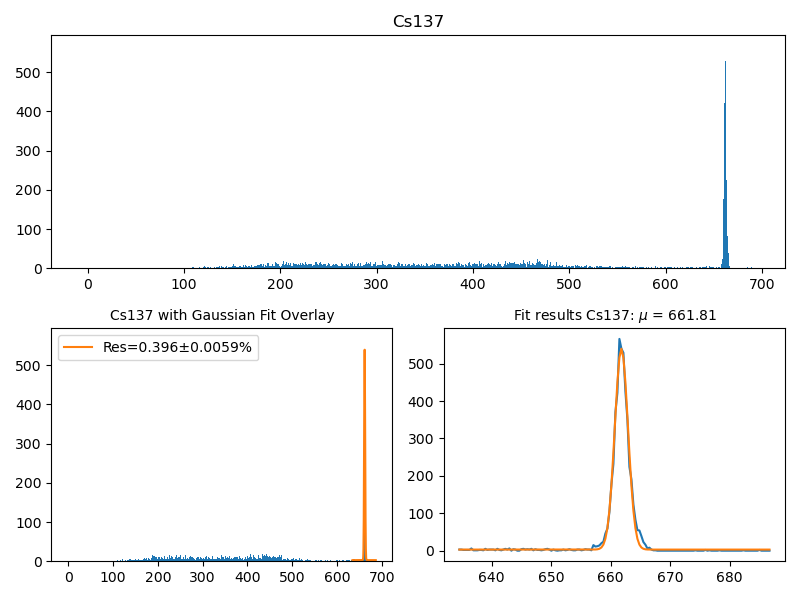

In [45]:
%matplotlib widget
_,PO = Get_Hist_Mus_calibrated_V2(Y=Tf,Upperlimit=1.95E+05,Del=8000,Source='Cs137',Calb=ECalb,
                                      num_peaks=1,num_bins=2**11)

# Old Unoptimized Distribution

[0.50917846 2.00852949 0.01863325 0.01953916]
The res is  0.8068062322657681
The uncertainty is 0.01656284281094485


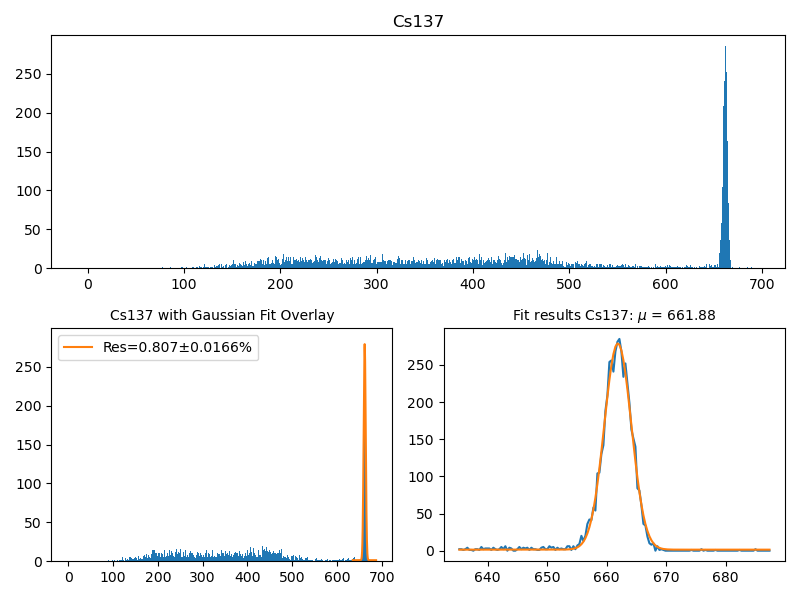

In [46]:
os.chdir(r'/Users/curtisberger/PythonPrograms/NE204/Lab1/DATA/Combined_Data')
Trapezoids = sio.loadmat('Lab1_Trapezoids_Echo.mat')
y_cs137 = Trapezoids['Cs137'].reshape(-1) # upperlimimt is 1.95E+05
_,PU = Get_Hist_Mus_calibrated_V2(Y=y_cs137, Upperlimit=1.95E+05 ,Del=8000, Source='Cs137',Calb=ECalb,
                           num_peaks=1,num_bins=2**11)

In [64]:
ComptomO = PO[1000]
PeakO = np.max(PO)
ComptomU = PU[1000]
PeakU = np.max(PU)

RatioO = PeakO/ComptomO
RatioU = PeakU/ComptomU
headers = ['Peak Counts','Compton Counts', 'Peak-to-Compton Ratio']
Tablah = [['Omptimized Spectrum', PeakO,ComptomO,RatioO],['Unomptimized Spectrum', PeakU,ComptomU,RatioU]]
print(tabulate(Tablah,headers,tablefmt='fancy_grid'))

╒═══════════════════════╤═══════════════╤══════════════════╤═════════════════════════╕
│                       │   Peak Counts │   Compton Counts │   Peak-to-Compton Ratio │
╞═══════════════════════╪═══════════════╪══════════════════╪═════════════════════════╡
│ Omptimized Spectrum   │           566 │               16 │                 35.375  │
├───────────────────────┼───────────────┼──────────────────┼─────────────────────────┤
│ Unomptimized Spectrum │           285 │               16 │                 17.8125 │
╘═══════════════════════╧═══════════════╧══════════════════╧═════════════════════════╛


# Create Pretty table

In [131]:
headers = ['Cluster Family Number', '#Signals in Cluster', 'K min[clock cycles]', 'Gap min[clock cycles]']
Tablah = zip(clust_nums, num_labels, Optimized_Ks, Optimized_Gaps)
print(tabulate(Tablah,headers,tablefmt='fancy_grid'))

╒═════════════════════════╤═══════════════════════╤═══════════════════════╤═════════════════════════╕
│   Cluster Family Number │   #Signals in Cluster │   K min[clock cycles] │   Gap min[clock cycles] │
╞═════════════════════════╪═══════════════════════╪═══════════════════════╪═════════════════════════╡
│                       0 │                   456 │                   300 │                     670 │
├─────────────────────────┼───────────────────────┼───────────────────────┼─────────────────────────┤
│                       1 │                   560 │                   330 │                     350 │
├─────────────────────────┼───────────────────────┼───────────────────────┼─────────────────────────┤
│                       2 │                   355 │                   300 │                     340 │
├─────────────────────────┼───────────────────────┼───────────────────────┼─────────────────────────┤
│                       3 │                   276 │                   300 │       

In [138]:
print(0.4*2)

0.8
